<a href="https://colab.research.google.com/github/NirantK/Hinglish/blob/all_berts/RoBERTaBase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

     |████████████████████████████████| 501kB 3.5MB/s 
     |████████████████████████████████| 870kB 63.2MB/s 
     |████████████████████████████████| 1.0MB 46.5MB/s 
     |████████████████████████████████| 3.7MB 32.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=a2916172698b57f5430f7751cf896beb85d5b424d667ff482c7a7455e82ddd29
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# !cp drive/My\ Drive/Hinglish/clean_data/train_lm_data.txt .
# !cp drive/My\ Drive/Hinglish/clean_data/dev_lm_data.txt .
# !cp drive/My\ Drive/Hinglish/clean_data/test_lm_data.txt .
# !cp drive/My\ Drive/run_language_modeling.py .

In [0]:
!head train_lm_data.txt

head: cannot open 'train_lm_data.txt' for reading: No such file or directory


In [0]:
!python run_language_modeling.py --output_dir=roberta3 --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=train_lm_data.txt --do_eval --eval_data_file=dev_lm_data.txt --mlm  --num_train_epochs 3 --save_total_limit 2 --overwrite_output_dir

python3: can't open file 'run_language_modeling.py': [Errno 2] No such file or directory


In [0]:
!cp -r roberta3 drive/My\ Drive/

cp: cannot stat 'roberta3': No such file or directory


In [0]:
import pandas as pd
train_df = pd.read_json("drive/My Drive/Hinglish/clean_data/train.json")
test_df = pd.read_json("drive/My Drive/Hinglish/clean_data/test.json")
sentences = train_df['clean_text']
labels = train_df['sentiment']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

In [0]:
import torch
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
    device = torch.device("cuda")
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
# !cp -r output drive/My\ Drive/

In [0]:
from transformers import RobertaTokenizer

# Load the Roberta tokenizer.
print('Loading Roberta tokenizer...')
tokenizer= RobertaTokenizer.from_pretrained(str("drive/My Drive/roberta3/"))
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")

print (tokenized_texts[0])
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning Roberta on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

from transformers import RobertaForSequenceClassification, AdamW, RobertaConfig

# Load RobertaForSequenceClassification, the pretrained Roberta model with a single 
# linear classification layer on top. 
model = RobertaForSequenceClassification.from_pretrained(
    "drive/My Drive/roberta3", # Use the 12-layer Roberta model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification. 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Loading Roberta tokenizer...
Tokenize the first sentence:
['Ġ', 'ĠI', 'ĠCAN', 'ĠâĢ', 'Ļ', 'ĠT', 'ĠEVEN', 'ĠBEL', 'IE', 'VE', 'ĠTHAT', 'ĠI', 'ĠâĢ', 'Ļ', 'ĠV', 'E', 'ĠGOT', 'ĠP', 'ICT', 'URES', 'ĠWITH', 'ĠMI', 'LEY', 'ĠFUCK', 'ING', 'ĠCY', 'R', 'US', 'ĠTHIS', 'ĠIS', 'ĠA', 'ĠFUCK', 'ING', 'ĠD', 'REAM', 'ĠCOM', 'E', 'ĠTRUE', 'Ġ:', 'l', 'oud', 'ly', '_', 'c', 'rying', '_', 'face', ':', 'ĠI', 'ĠLOVE', 'ĠYOU', 'ĠMORE', 'ĠTH', 'ĠâĢ¦']
Original:    I CAN ’ T EVEN BELIEVE THAT I ’ VE GOT PICTURES WITH MILEY FUCKING CYRUS THIS IS A FUCKING DREAM COME TRUE :loudly_crying_face: I LOVE YOU MORE TH …  
Token IDs: [0, 1437, 38, 12471, 44, 27, 255, 40416, 36125, 7720, 8856, 24394, 38, 44, 27, 468, 717, 42007, 221, 12894, 28714, 17345, 10931, 17945, 46997, 1862, 32854, 500, 3048, 10652, 3703, 83, 46997, 1862, 211, 28057, 15823, 717, 44929, 4832, 462, 6998, 352, 1215, 438, 15975, 1215, 9021, 35, 38, 31124, 10540, 3001, 8640, 1555, 2]

Padding/truncating all sentences to 128 values...

Padding token: "<pa

Using TensorFlow backend.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 4e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 8

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_prf(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_recall_fscore_support(labels_flat, pred_flat, labels =[0,1,2],average='macro')

from sklearn.metrics import f1_score

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []



The BERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

In [0]:
from sklearn.metrics import precision_recall_fscore_support


In [0]:
def run_valid():
  # ========================================
  #               Validation
  # ========================================
  # After the completion of each training epoch, measure our performance on
  # our validation set.

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  eval_p =0
  eval_r =0
  eval_f1 =0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
      
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and
      # speeding up validation
      with torch.no_grad():        

          # Forward pass, calculate logit predictions.
          # This will return the logits rather than the loss because we have
          # not provided labels.
          # token_type_ids is the same as the "segment ids", which 
          # differentiates sentence 1 and 2 in 2-sentence tasks.
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids,  
                          attention_mask=b_input_mask)
      
      # Get the "logits" output by the model. The "logits" are the output
      # values prior to applying an activation function like the softmax.
      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Calculate the accuracy for this batch of test sentences.
      tmp_eval_accuracy = flat_accuracy(logits,label_ids)
      temp_eval_f1 = flat_prf(logits, label_ids)

      # Accumulate the total accuracy.
      eval_accuracy += tmp_eval_accuracy
      eval_p += temp_eval_f1[0]
      eval_r += temp_eval_f1[1]
      eval_f1 += temp_eval_f1[2]

      # Track the number of batches
      nb_eval_steps += 1

  # Report the final accuracy for this validation run.
  print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
  print(f"  Precision, Recall F1: {eval_p/nb_eval_steps}, {eval_r/nb_eval_steps}, {eval_f1/nb_eval_steps}")
  print("  Validation took: {:}".format(format_time(time.time() - t0)))
  # Report progress.
  

In [0]:
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

        if step % 40 == 0 and not step == 0:
            run_valid()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 8 ========
Training...
  Batch    40  of    383.    Elapsed: 0:00:16.

Running Validation...
  Accuracy: 0.57
  Precision, Recall F1: 0.5999476577280954, 0.5875152118996166, 0.5654966527922439
  Validation took: 0:00:05
  Batch    80  of    383.    Elapsed: 0:00:36.

Running Validation...
  Accuracy: 0.57
  Precision, Recall F1: 0.5750153757677696, 0.5842940265135886, 0.5632024060149321
  Validation took: 0:00:05
  Batch   120  of    383.    Elapsed: 0:00:56.

Running Validation...
  Accuracy: 0.58
  Precision, Recall F1: 0.6030049211820757, 0.5880639171336844, 0.5756525006280925
  Validation took: 0:00:05
  Batch   160  of    383.    Elapsed: 0:01:17.

Running Validation...
  Accuracy: 0.59
  Precision, Recall F1: 0.5931365596694274, 0.6016118027232938, 0.5816143349745572
  Validation took: 0:00:05
  Batch   200  of    383.    Elapsed: 0:01:37.

Running Validation...
  Accuracy: 0.57
  Precision, Recall F1: 0.6107545858103073, 0.5947922422614625, 0.5421579641708862

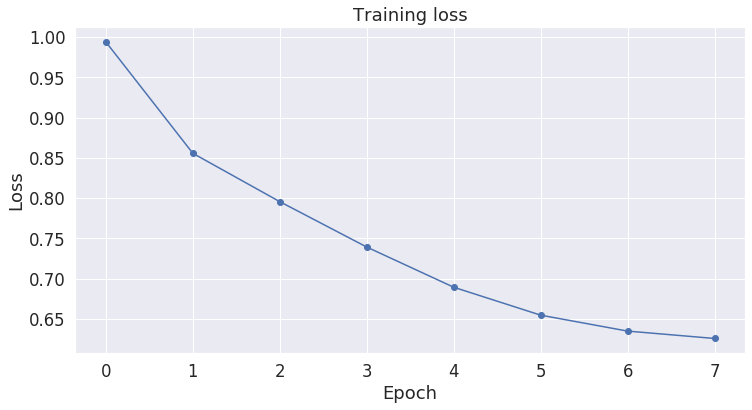

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
sentences = test_df['clean_text']
labels = test_df['sentiment']
labels = le.transform(labels)
# Report the number of sentences.

# Create sentence and label lists
# sentences = df.sentence.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,400 test sentences...
    DONE.


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))
from sklearn.metrics import f1_score
f1_score(flat_predictions, flat_true_labels, average='macro')

Calculating Matthews Corr. Coef. for each batch...
MCC: 0.395
Saving model to ./model_save/


0.6024245791359627

In [0]:
final_test_df = pd.read_json("drive/My Drive/Hinglish/clean_data/test.json")
sentences = final_test_df['clean_text']
# Report the number of sentences.

# Create sentence and label lists
# sentences = df.sentence.values
# labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on valid set

print('Predicting labels for {:,} valid sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  
  # Store predictions and true labels
  predictions.append(logits)

print('    DONE.')


# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()


Predicting labels for 3,400 valid sentences...
    DONE.


In [0]:
len(flat_predictions.tolist())

3400

In [0]:
output = le.inverse_transform(flat_predictions.tolist())
output_df = pd.DataFrame({
    'Uid':list(final_test_df['uid']),
    'Sentiment':output,
    'clean_text':list(final_test_df['clean_text'])
})

output_df

,Uid,Sentiment,clean_text
0,16677,neutral,_ national Baba Ramdev sahi farma rahey hey...
1,16986,positive,Hamare nabinji odissa c m congratulations apko...
2,12168,negative,maa ko pairo se nahi raunda jata .... kya ko...
3,6598,neutral,Ab kia kia es me sharat bhi nhi ki sad bnai ...
4,26490,negative,pallavighosh Food packet choro gaadi pe kapad...
...,...,...,...
3395,23883,neutral,Neetesh kumar palti maar Baba hein yeh log ap...
3396,25574,negative,Jiske naam pe filme chlti thi na wo usse desh...
3397,12528,negative,Chal be dalle sale hrami ke pille . Haven'...
3398,17592,negative,NDTV wale kutte ki maut aur mulle ki maut pa...


In [0]:
proba = [item for sublist in predictions for item in sublist]
preds = np.argmax(proba, axis=1).flatten()
full_output = output_df
full_output['proba_negative'] = pd.DataFrame(proba)[0]
full_output['proba_neutral'] = pd.DataFrame(proba)[1]
full_output['proba_positive'] = pd.DataFrame(proba)[2]
full_output['actual'] = final_test_df['sentiment']
full_output

,Uid,Sentiment,clean_text,proba_negative,proba_neutral,proba_positive,actual
0,16677,neutral,_ national Baba Ramdev sahi farma rahey hey...,-0.513532,0.355264,0.062693,positive
1,16986,positive,Hamare nabinji odissa c m congratulations apko...,-1.668507,0.036475,2.550894,positive
2,12168,negative,maa ko pairo se nahi raunda jata .... kya ko...,1.539013,-0.010099,-1.586211,negative
3,6598,neutral,Ab kia kia es me sharat bhi nhi ki sad bnai ...,-0.293383,0.777293,-0.536489,neutral
4,26490,negative,pallavighosh Food packet choro gaadi pe kapad...,0.983770,0.922158,-1.538243,neutral
...,...,...,...,...,...,...,...
3395,23883,neutral,Neetesh kumar palti maar Baba hein yeh log ap...,0.002433,0.986292,-0.735069,neutral
3396,25574,negative,Jiske naam pe filme chlti thi na wo usse desh...,1.553486,-0.545052,-1.330889,neutral
3397,12528,negative,Chal be dalle sale hrami ke pille . Haven'...,1.376868,0.272388,-1.626022,negative
3398,17592,negative,NDTV wale kutte ki maut aur mulle ki maut pa...,1.071574,-0.117672,-1.283891,negative


In [0]:
f1_score(full_output["Sentiment"], full_output["actual"], average="macro")

0.6024245791359627

In [0]:
full_output.to_csv("drive/My Drive/RobeBERT_valid60.csv")

In [0]:
output_df.to_csv("drive/My Drive/roberta3/robertaOutput.csv", index=False)

In [0]:
with open('answer.txt', 'w') as f:
    for i in range(len(output.tolist())):
        f.write(f"{final_test_df.loc[i]['uid']},{output[i]}\n")